In [3]:
import pandas as pd
import numpy as np
from sklearn.cluster import MeanShift as ms
from scipy.spatial import distance

In [4]:
data = pd.read_table('checkins.dat', na_values="NaN")

In [9]:
data.head

<bound method NDFrame.head of            id    | user_id | venue_id |     latitude      |     longitude     |     created_at      
0        ---------+---------+----------+---------------...                                          
1          984301 | 2041916 |     5222 |               ...                                          
2          984222 |   15824 |     5222 |        38.8951...                                          
3          984315 | 1764391 |     5222 |               ...                                          
4          984234 |   44652 |     5222 |         33.800...                                          
5          984249 | 2146840 |     5222 |               ...                                          
6          984268 | 2146843 |     5222 |               ...                                          
7          984281 | 2146846 |     5222 |               ...                                          
8          984291 |  105054 |     5222 |        45.5234...   

In [169]:
data = pd.read_table('checkins.dat', sep='|', skipinitialspace = True, 
                     skiprows=[1], header=0, names=('id', 'user_id', 'venue_id', 'latitude', 'longitude', 'created_at'))
data.dropna(axis='rows', inplace=True)

C:\Users\dvmos\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [138]:
meanshift = ms(bandwidth=0.1)

In [170]:
data = data[:100000]

In [191]:
%%time
meanshift.fit(data[['latitude', 'longitude']])

Wall time: 5min 26s


MeanShift(bandwidth=0.1, bin_seeding=False, cluster_all=True, min_bin_freq=1,
     n_jobs=None, seeds=None)

In [192]:
# Вытащим из обученного метода массивы с метками наших точек и координатами центров кластеров

labels = meanshift.labels_
cluster_centers = meanshift.cluster_centers_

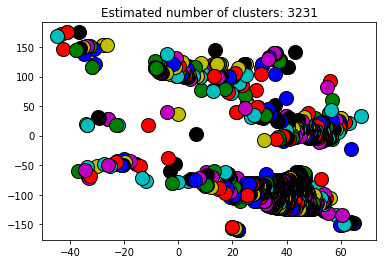

In [213]:
# График кластеров

import matplotlib.pyplot as plt
from itertools import cycle
X = np.array(data[['latitude', 'longitude']])
plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(X[my_members, 0], X[my_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [242]:
# Найдем уникальные метки и посчитаем для каждой их количество в списке, который содержит метки для каждой точки выборки
# результатом будет кортеж, в котором нулевой массив это уникальные метки, а первый массив это счетчик объектов с соответсвующими метками

labels_unique = np.unique(labels, return_counts=True)

In [251]:
# Найдем индексы тех меток, количество объекто для которых больше 15

y = np.where(labels_unique[1]>15)

In [261]:
# Создадим список кластеров, с количеством объектов более 15

realclusters = []
for i in y[0]:
    realclusters.append(cluster_centers[i])

In [264]:
len(realclusters)

592

In [269]:
# Получим координаты кластеров в формате, подходящем для чтения на сайте www.mapcustomizer.com

with open('coordinates.txt', 'w') as file:
    for i in realclusters:
        for j in str(i).replace('[', '').replace(']', ''.replace(' ', '')).split():
            file.write(str(i).replace('[', '').replace(']', ''.replace(' ', '')).split()[0])
            file.write(',')
            file.write(str(i).replace('[', '').replace(']', ''.replace(' ', '')).split()[1])
            file.write('\n')

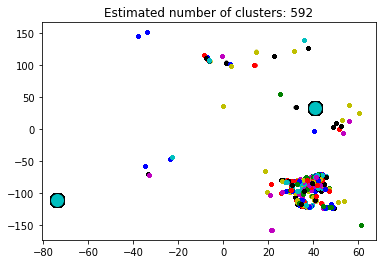

In [271]:
# Кластеры после оптимизации

import matplotlib.pyplot as plt
from itertools import cycle

plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(len(realclusters)), colors):
    my_members = labels == k
    cluster_center = realclusters[k]
    plt.plot(X[my_members, 0], X[my_members, 1], col + '.')
    plt.plot(realclusters[0], realclusters[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
plt.title('Estimated number of clusters: %d' % len(realclusters))
plt.show()

In [284]:
#Создадим словарь с координатами офисов компании

offices = {'LA': [33.751277, -118.188740], 'Miami': [25.867736, -80.324116], 'London':[51.503016, -0.075479], 
     'Amsterdam':[52.378894, 4.885084], 'Beijing':[39.366487, 117.036146], 'Sydney':[-33.868457, 151.205134]}

In [ ]:
# Определим функцию для вычисления евклидовой метрики

def dst(a, b):
    return distance.euclidean(a, b)

In [391]:
# для каждой точки сравним ее расстояние до каждого из офисов и выберем наименьшее

s = []
distances = []
for j in realclusters:
    s= []
    for key, value in offices.items():
        s.append(dst(value, j))
    distances.append(min(s))

592

In [392]:
# отсортируем расстояния и возьмем 20 наименьших
minimalvalues = sorted(distances)[0:20]
minimalvalues = np.array(minimalvalues)

In [383]:
# Получим массив с индексами координат точек, которые являются популярными и находятся ближе всего к офису компании

ind = []
for i in minimalvalues:
    ind.append(np.where(distances == i)[0][0])

In [384]:
# Получим искомые координаты

targets = []
for i in ind:
    targets.append(realclusters[i])

In [401]:
# Найдем координаты  наименьшим расстоянием до ближайшего офиса и заодно выполним проверку

distances = np.array(distances)
realclusters[np.where(distances == min(distances))[0][0]]

array([-33.86063043, 151.20477593])

In [ ]:
# Как можно легко убедиться полученные координаты соответствуют нулевому значению в нашем списке targets, 
#который является отсортированным